In [20]:
import numpy as np 
import matplotlib.pyplot as plt
from matplotlib.colors import rgb2hex
from matplotlib.patches import Polygon
import matplotlib.mlab as mlab
import pandas as pd
from mpl_toolkits import mplot3d
import scipy as sp
from scipy import stats as stt
from sklearn import datasets, linear_model
from sklearn.neighbors import KernelDensity as kd
from sklearn.linear_model import LinearRegression
from scipy.stats import norm
import statsmodels
import sklearn
from datetime import date
from scipy.stats import norm, kurtosis
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, explained_variance_score, confusion_matrix, accuracy_score
import seaborn as sns
import statsmodels.api as sm 
from sklearn.cluster import KMeans, k_means
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

#### Reading data

In [21]:
data = pd.read_csv("Bike_Crash_Analysis.csv", )

#### Removing unwanted features

In [22]:
data = data.drop("REPORTING_DISTRICT",axis=1)
data = data.drop("PROC_DATE",axis=1)
data = data.drop("COLLISION_DATE",axis=1)
data = data.drop("POPULATION",axis=1)
data = data.drop("PRIMARY_RD", axis = 1)
data = data.drop("ACCIDENT_YEAR", axis = 1)
data = data.drop("JURIS", axis = 1)
data = data.drop("SECONDARY_RD", axis = 1)
data = data.drop("CITY", axis = 1)
data = data.dropna(subset=['CHP_VEHTYPE_AT_FAULT'])
data = data.fillna(0)

#### Checkpoint to further simplify usefull data, and catagorize binomial features 

In [23]:
simpledata= data
simpledata= simpledata.drop('CASE_ID',axis=1)
simpledata= simpledata.drop('CHP_VEHTYPE_AT_FAULT',axis=1)
simpledata= simpledata.drop('BICYCLE_ACCIDENT',axis=1)
simpledata= simpledata.drop('STATE_HWY_IND',axis=1)
simpledata= simpledata.drop('PARTY_COUNT',axis=1)
simpledata = simpledata.replace({'INTERSECTION': 'N'}, 0)
simpledata = simpledata.replace({'INTERSECTION': 'Y'}, 1)
simpledata = simpledata.replace({'ALCOHOL_INVOLVED': 'Y'}, 1)
simpledata= simpledata.drop('PED_ACTION',axis=1)
simpledata= simpledata.drop('ROAD_SURFACE',axis=1)
simpledata = simpledata.drop('COUNT_VISIBLE_INJ',axis = 1)
simpledata = simpledata.drop('COUNT_COMPLAINT_PAIN',axis=1)
simpledata = simpledata.drop('NUMBER_INJURED',axis=1)
simpledata = simpledata.drop('NUMBER_KILLED',axis=1)
simpledata = simpledata.drop('COUNT_SEVERE_INJ',axis=1)
simpledata = simpledata.drop('HIT_AND_RUN',axis=1)
simpledata = simpledata.drop('CONTROL_DEVICE',axis=1)

#### Transforming time into bins for catagorization 

In [24]:
bins= [0,199,599,999,1399,1799,2199,2400]
labels = ['Late Night','Early Morning','Morning','Noon','Evening','Night', 'Late Night']
simpledata['COLLISION_TIME'] = pd.cut(simpledata['COLLISION_TIME'], bins=bins, labels=labels, ordered =False, right= True)

#### Creating new features based off old ones, such as "Weekdays" or "Injuries 2+"

In [25]:
simplerdata= simpledata
simplerdata = pd.get_dummies(simplerdata, columns=['INTERSECTION','COLLISION_TIME', 'DAY_OF_WEEK','COUNT_BICYCLIST_KILLED','COUNT_BICYCLIST_INJURED','WEATHER_1','COLLISION_SEVERITY','PRIMARY_COLL_FACTOR','TYPE_OF_COLLISION','MVIW','ROAD_COND_1','LIGHTING','STWD_VEHTYPE_AT_FAULT'])
simplerdata= simplerdata.drop('WEATHER_1_-',axis=1)
simplerdata= simplerdata.drop('PRIMARY_COLL_FACTOR_-',axis=1)
simplerdata= simplerdata.drop('STWD_VEHTYPE_AT_FAULT_-',axis=1)
simplerdata= simplerdata.drop('TYPE_OF_COLLISION_-',axis=1)
simplerdata= simplerdata.drop('ROAD_COND_1_-',axis=1)
simplerdata= simplerdata.drop('LIGHTING_-',axis=1)
simplerdata= simplerdata.drop('MVIW_-',axis=1)
simplerdata= simplerdata.drop('INTERSECTION_-',axis=1)
simplerdata= simplerdata.drop('INTERSECTION_0',axis=1)
WEEKDAYS = simplerdata["DAY_OF_WEEK_1"] + simplerdata["DAY_OF_WEEK_2"] +simplerdata["DAY_OF_WEEK_3"] +simplerdata["DAY_OF_WEEK_4"] +simplerdata["DAY_OF_WEEK_5"] 
simplerdata["WEEKDAYS"] = WEEKDAYS
simplerdata = simplerdata.drop('DAY_OF_WEEK_1',axis=1)
simplerdata = simplerdata.drop('DAY_OF_WEEK_2',axis=1)
simplerdata = simplerdata.drop('DAY_OF_WEEK_3',axis=1)
simplerdata = simplerdata.drop('DAY_OF_WEEK_4',axis=1)
simplerdata = simplerdata.drop('DAY_OF_WEEK_5',axis=1)
WEEKENDS = simplerdata["DAY_OF_WEEK_6"] + simplerdata["DAY_OF_WEEK_7"]
simplerdata["WEEKENDS"] = WEEKENDS
simplerdata = simplerdata.drop('DAY_OF_WEEK_6',axis=1)
simplerdata = simplerdata.drop('DAY_OF_WEEK_7',axis=1)
COUNT_BICYCLIST_INJURED_2_PLUS = simplerdata["COUNT_BICYCLIST_INJURED_2"] + simplerdata["COUNT_BICYCLIST_INJURED_3"] +simplerdata["COUNT_BICYCLIST_INJURED_4"] +simplerdata["COUNT_BICYCLIST_INJURED_5"] +simplerdata["COUNT_BICYCLIST_INJURED_11"] 
simplerdata["COUNT_BICYCLIST_INJURED_2_PLUS"] = COUNT_BICYCLIST_INJURED_2_PLUS
simplerdata = simplerdata.drop('COUNT_BICYCLIST_INJURED_2',axis=1)
simplerdata = simplerdata.drop('COUNT_BICYCLIST_INJURED_3',axis=1)
simplerdata = simplerdata.drop('COUNT_BICYCLIST_INJURED_4',axis=1)
simplerdata = simplerdata.drop('COUNT_BICYCLIST_INJURED_5',axis=1)
simplerdata = simplerdata.drop('COUNT_BICYCLIST_INJURED_11',axis=1)
simplerdata = simplerdata.drop('COUNT_BICYCLIST_KILLED_0',axis=1)
simplerdata = simplerdata.drop('COUNT_BICYCLIST_INJURED_0',axis=1)

#### Testing various cluster sizes

In [26]:
model = simplerdata.values
kmeans = KMeans(n_clusters = 3, random_state = 540)
kmeans = kmeans.fit(model)
print(kmeans.inertia_)

32157.671449673035


In [27]:
numclusters= range(2,20)
inertia=[]
for f in numclusters:
    kmeans = KMeans(n_clusters = f, random_state = 2)
    kmeans = kmeans.fit(model)
    u = kmeans.inertia_
    inertia.append(u)
    print("The inertia for ", f, "clusters is :", u)

The inertia for  2 clusters is : 34661.203358903374
The inertia for  3 clusters is : 32157.671449673035
The inertia for  4 clusters is : 30296.568957705564
The inertia for  5 clusters is : 29076.876617915397
The inertia for  6 clusters is : 28173.49214311166
The inertia for  7 clusters is : 27533.30327370244
The inertia for  8 clusters is : 27044.656723502292
The inertia for  9 clusters is : 26433.611430485376
The inertia for  10 clusters is : 25763.41112065125
The inertia for  11 clusters is : 25452.82649161507
The inertia for  12 clusters is : 24981.883683177126
The inertia for  13 clusters is : 24459.47264683208
The inertia for  14 clusters is : 24380.175912248687
The inertia for  15 clusters is : 23866.921696740366
The inertia for  16 clusters is : 23641.834987924416
The inertia for  17 clusters is : 23166.681413733324
The inertia for  18 clusters is : 22997.457891409573
The inertia for  19 clusters is : 22785.364860475842


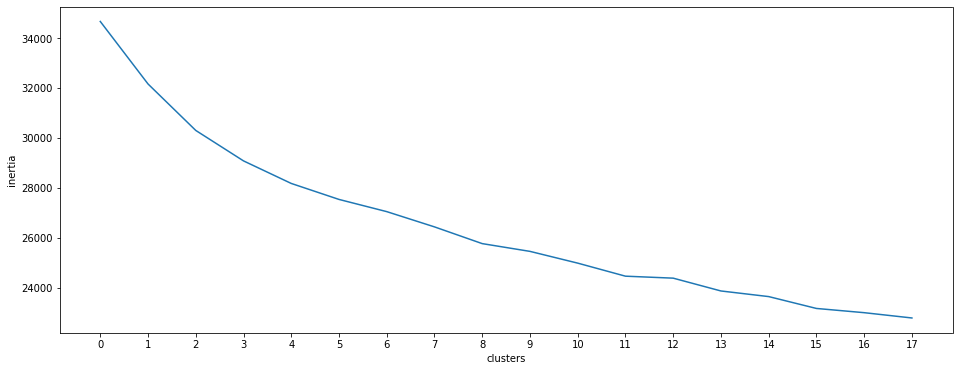

In [28]:
fig, (ax1) = plt.subplots(1, figsize = (16,6))
x = np.arange(len(numclusters))
ax1.plot(x,inertia)
ax1.set_xticks(x)
plt.xlabel('clusters')
plt.ylabel('inertia')
plt.show()

In [29]:
kmeans = KMeans(n_clusters = 4, random_state = 2)
kmeans = kmeans.fit(model)
predictions = kmeans.predict(model)
unique, counts = np.unique(predictions, return_counts = True)
counts = counts.reshape(1,4)
clustercount= pd.DataFrame(counts, columns = ["Cluster 1", "Cluster 2", "Cluster 3","Cluster 4"])
clustercount

,Cluster 1,Cluster 2,Cluster 3,Cluster 4
0,1871,3069,2005,1547


In [30]:
total = 1871 + 3069 + 2005 + 1547 
clus1 = 1871/total * 100 
clus1 = round(clus1, 2)
clus2 = 3069/total * 100 
clus2 = round(clus2, 2)
clus3 = 2005/total * 100 
clus3 = round(clus3, 2)
clus4 = 1547/total * 100 
clus4 = round(clus4, 2)
print("Percentage of total per cluster ","\nCluster 1 : ", clus1,"\nCluster 2 : ", clus2,"\nCluster 3 : ", clus3,"\nCluster 4 : ", clus4)

Percentage of total per cluster  
Cluster 1 :  22.03 
Cluster 2 :  36.14 
Cluster 3 :  23.61 
Cluster 4 :  18.22


<Figure size 432x288 with 0 Axes>

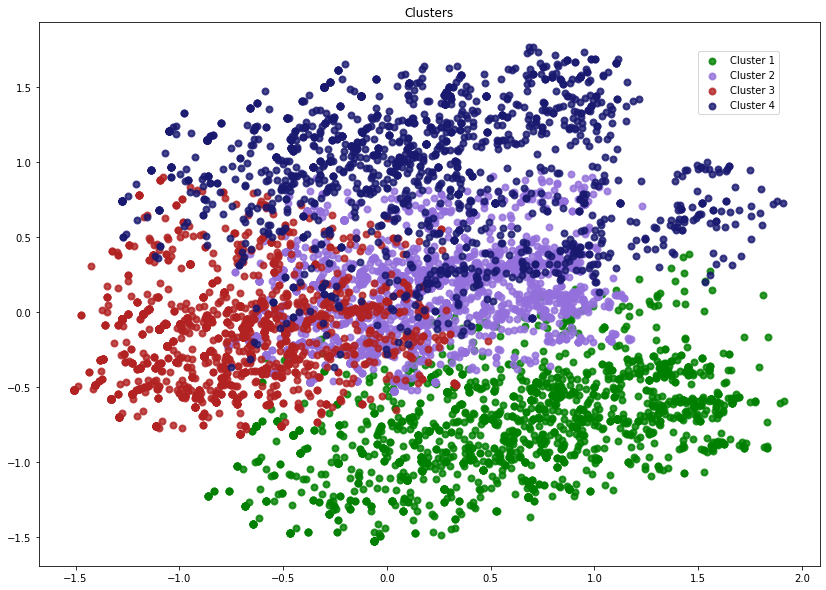

In [31]:
x = model
y = predictions
names = ["Cluster 1", "Cluster 2", "Cluster 3","Cluster 4"]
pca = PCA(n_components='mle', random_state = 543)
xr = pca.fit(x).transform(x)
plt.figure()
plt.figure(figsize=(14,10))
colors = ['green', 'mediumpurple', 'firebrick', 'midnightblue']
lw =2
for colors, i, names in zip(colors,[0,1,2,3], names):
    plt.scatter(xr[y==i, 0], xr[y==i, 1], color = colors, alpha = .8, lw = lw, label = names)

plt.legend(loc ='best', shadow = False, scatterpoints = 1)
plt.legend(bbox_to_anchor=(0.95, 0.95), loc='best', borderaxespad = 0.2)
plt.title('Clusters')
plt.show()

In [37]:
total_variance=sum(pca.explained_variance_)
print("explained variance is : ", total_variance)

explained variance is :  4.488605374353034


In [33]:
n_components = x.shape[1]
pca = PCA(n_components = n_components, random_state = 453)
xr = pca.fit(x).transform(x)

In [34]:
a = zip(range(0,n_components), pca.explained_variance_)
a = pd.DataFrame(a, columns = ["PCA COMP","EXPLAINED VARIANCE",])

In [35]:
print("variance explain with 25 components: ", sum(a["EXPLAINED VARIANCE"][0:25]))
print("variance explain with 26 components: ", sum(a["EXPLAINED VARIANCE"][0:26]))
print("variance explain with 27 components: ", sum(a["EXPLAINED VARIANCE"][0:27]))
print("variance explain with 28 components: ", sum(a["EXPLAINED VARIANCE"][0:28]))
print("variance explain with 29 components: ", sum(a["EXPLAINED VARIANCE"][0:29]))
print("variance explain with 30 components: ", sum(a["EXPLAINED VARIANCE"][0:30]))

variance explain with 25 components:  4.1774787332578285
variance explain with 26 components:  4.209519296187662
variance explain with 27 components:  4.238748609987809
variance explain with 28 components:  4.264079014729958
variance explain with 29 components:  4.287189763801547
variance explain with 30 components:  4.309359973286411


In [36]:
simplerdata["cluster"] = predictions